In [ ]:
pip install torch numpy matplotlib scikit-learn seaborn

In [24]:
# 1. Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# 2. Generate and Prepare Data
X, y = make_classification(n_samples=1000, n_features=10, n_classes=5,
                           n_informative=5, n_redundant=0, random_state=42)

# Visualize the data: Plot first two dimensions for easy visualization
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.title("Synthetic Classification Data (First 2 Features)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Class')
plt.show()

# Display some basic statistics of the dataset
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"First 5 samples (X):\n{X[:5]}")
print(f"First 5 labels (y):\n{y[:5]}")

# ------------------------------
# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the split datasets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Display the first 5 samples after scaling
print(f"First 5 samples of X_train after scaling:\n{X_train[:5]}")
print(f"First 5 samples of X_test after scaling:\n{X_test[:5]}")

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Confirm the conversion to tensors
print(f"X_train tensor shape: {X_train.shape}")
print(f"X_test tensor shape: {X_test.shape}")
print(f"y_train tensor shape: {y_train.shape}")
print(f"y_test tensor shape: {y_test.shape}")

In [26]:
# ------------------------------
# 3. Define the neural network with a switch for PReLU or Tanh
# ------------------------------
class ClassificationNN(nn.Module):
    def __init__(self, input_size, num_classes, activation_func="PReLU"):
        """
        Initialize the model with the specified activation function.
        :param input_size: The size of the input features.
        :param num_classes: The number of output classes.
        :param activation_func: Choose "PReLU" or "Tanh" as the activation function.
        """
        super(ClassificationNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)  # Output layer (no activation, use CrossEntropyLoss)
        self.dropout = nn.Dropout(0.2)  # Dropout for regularization

        # Choose activation function based on the parameter passed
        if activation_func == "PReLU":
            self.activation = nn.PReLU()  # PReLU activation function
        elif activation_func == "Tanh":
            self.activation = nn.Tanh()   # Tanh activation function
        else:
            raise ValueError("Invalid activation function. Choose either 'PReLU' or 'Tanh'.")

    def forward(self, x):
        x = self.activation(self.fc1(x))  # First layer with activation
        x = self.dropout(x)
        x = self.activation(self.fc2(x))  # Second layer with activation
        x = self.dropout(x)
        x = self.fc3(x)                   # Output layer (logits)
        return x

In [ ]:
# ------------------------------
# 4. Initialize model, loss, optimizer
# ------------------------------
input_size = X_train.shape[1]
num_classes = len(torch.unique(y_train))

# Switch to choose activation function ("PReLU" or "Tanh")
activation_choice = "PReLU"  # Change this to "Tanh" to use Tanh activation function

model = ClassificationNN(input_size, num_classes, activation_func=activation_choice)

# Loss Function: CrossEntropyLoss includes LogSoftmax internally
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model, loss, optimizer
print("\nModel Architecture with", activation_choice, "activation function:\n", model)
print("\nLoss Function:", criterion)
print("Optimizer:", optimizer)

In [ ]:
# ------------------------------
# 5. Train the model
# ------------------------------
epochs = 200
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_train).sum().item()
    train_accuracies.append(correct / len(y_train))

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

        _, test_pred = torch.max(test_outputs, 1)
        correct_test = (test_pred == y_test).sum().item()
        test_accuracies.append(correct_test / len(y_test))

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f} "
              f"| Train Acc: {train_accuracies[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")

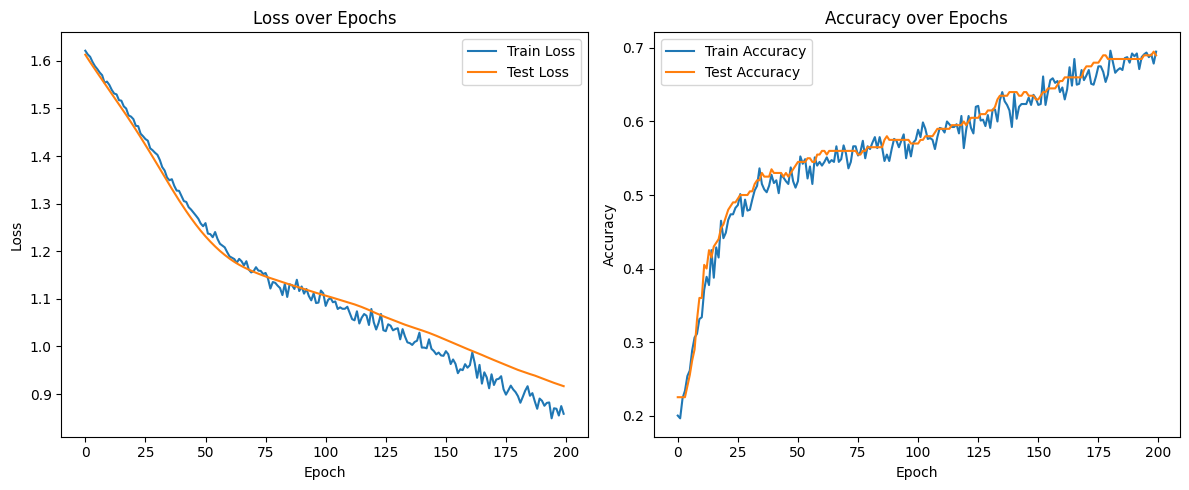

In [29]:
# ------------------------------
# 6. Plot Loss and Accuracy
# ------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.71      0.67        31
           1       0.76      0.69      0.72        42
           2       0.69      0.67      0.68        43
           3       0.65      0.60      0.62        40
           4       0.71      0.77      0.74        44

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.69      0.69      0.69       200



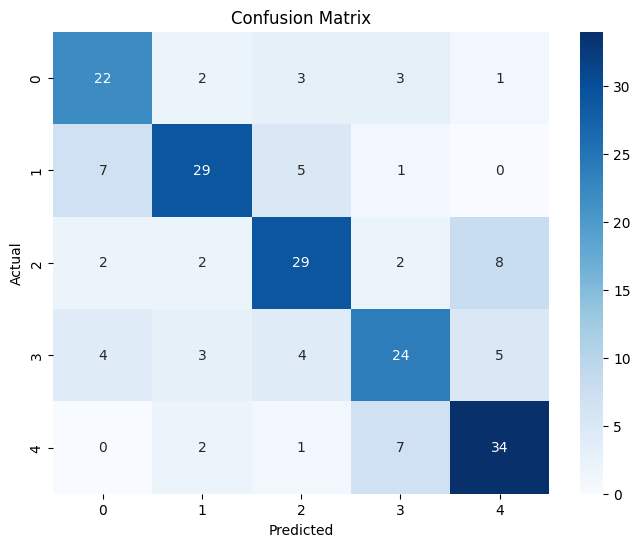


Sample Predictions:
Input 1 => Predicted: 3, Actual: 4
Input 2 => Predicted: 2, Actual: 0
Input 3 => Predicted: 3, Actual: 3
Input 4 => Predicted: 1, Actual: 1
Input 5 => Predicted: 4, Actual: 3


In [30]:
# ------------------------------
# 7. Classification Report and Confusion Matrix
# ------------------------------
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    _, y_pred = torch.max(y_pred, 1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ------------------------------
# 8. Sample predictions
# ------------------------------
with torch.no_grad():
    sample_inputs = X_test[:5]
    predictions = model(sample_inputs)
    _, predicted_classes = torch.max(predictions, 1)
    actual_classes = y_test[:5]

    print("\nSample Predictions:")
    for i in range(5):
        print(f"Input {i+1} => Predicted: {predicted_classes[i].item()}, Actual: {actual_classes[i].item()}")
